In [2]:
# Install RAPIDS (takes ~10 min).
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

# https://github.com/NVIDIA/NVTabular/blob/main/examples/winning-solution-recsys2020-twitter/01-02-04-Download-Convert-ETL-with-NVTabular-Training-with-XGBoost.ipynb     

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 205 (delta 16), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (205/205), 62.72 KiB | 12.54 MiB/s, done.
Resolving deltas: 100% (78/78), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals

In [3]:
# Needed to fix conda and install nvtabular.
!conda install https://repo.anaconda.com/pkgs/main/linux-64/conda-4.9.2-py37h06a4308_0.tar.bz2
!pip install git+https://github.com/NVIDIA/NVTabular.git@main


conda-4.9.2          | : 100% 1.0/1 [00:00<00:00,  1.23it/s]
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
  Cloning https://github.com/NVIDIA/NVTabular.git (to revision main) to /tmp/pip-req-build-v1cw7ywe
  Running command git clone -q https://github.com/NVIDIA/NVTabular.git /tmp/pip-req-build-v1cw7ywe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nvtabular: filename=nvtabular-0.4.0+19.gdd1c8b6-py3-none-any.whl size=206846 sha256=f11b7c4eb6b15280540805bd068500df7cf37df275ff6fbfd5a6fd3f87865d6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-kvub49a0/wheels/32/74/7c/e2d323de42120f4cefc10fb3fe2543f6c7558bf7c7b3a021c5
Successfully built nvtabular


In [ ]:
# For rapidsai 0.19 ONLY, not working.
"""
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test

!sudo apt-get update

!sudo apt-get install gcc-4.9

!sudo apt-get upgrade libstdc++6
!sudo apt-get dist-upgrade
!strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX"""

'\n!sudo add-apt-repository ppa:ubuntu-toolchain-r/test\n\n!sudo apt-get update\n\n!sudo apt-get install gcc-4.9\n\n!sudo apt-get upgrade libstdc++6\n!sudo apt-get dist-upgrade\n!strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX'

In [4]:
# External Dependencies
import time
import glob
import gc

import cupy as cp          # CuPy is an implementation of NumPy-compatible multi-dimensional array on GPU
import cudf                # cuDF is an implementation of Pandas-like Dataframe on GPU
import rmm                 # library for pre-allocating memory on GPU
import dask                # dask is an open-source library to nateively scale Python on multiple workers/nodes
import dask_cudf           # dask_cudf uses dask to scale cuDF dataframes on multiple workers/nodes

import numpy as np
# NVTabular is the core library, we will use here for feature engineering/preprocessing on GPU
import nvtabular as nvt
import xgboost as xgb

# More dask / dask_cluster related libraries to scale NVTabular
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.distributed import wait
from dask.utils import parse_bytes
from dask.delayed import delayed
from nvtabular.utils import device_mem_size
from nvtabular.column_group import ColumnGroup

In [1]:
!nvidia-smi

Mon Apr  5 19:04:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
time_total_start = time.time()

In [6]:
# Assume dataset in MyDrive/RecSys2021
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/RecSys2021/'

Mounted at /content/drive


In [40]:
cluster = LocalCUDACluster(
    protocol="tcp"
)
client = Client(cluster)
client

/usr/local/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40411 instead
  http_address["port"], self.http_server.port
/usr/local/lib/python3.7/site-packages/distributed/client.py:1140: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:40357 Dashboard: http://127.0.0.1:40411/status,Cluster Workers: 1 Cores: 1 Memory: 12.72 GiB


In [41]:
# Preparing our dataset

features = [
    'text_tokens',    ###############
    'hashtags',       #Tweet Features
    'tweet_id',       #
    'media',          #
    'links',          #
    'domains',        #
    'tweet_type',     #
    'language',       #
    'timestamp',      ###############
    'a_user_id',              ###########################
    'a_follower_count',       #Engaged With User Features
    'a_following_count',      #
    'a_is_verified',          #
    'a_account_creation',     ###########################
    'b_user_id',              #######################
    'b_follower_count',       #Engaging User Features
    'b_following_count',      #
    'b_is_verified',          #
    'b_account_creation',     #######################
    'b_follows_a',    #################### Engagement Features
    'reply',          #Target Reply
    'retweet',        #Target Retweet    
    'retweet_comment',#Target Retweet with comment
    'like',           #Target Like
                      ####################
]

In [43]:
# Splits the entries in media by \t and keeps only the first two values (if available).
def splitmedia(col):
    if col.shape[0] == 0:
        return(col)
    else:
        return(col) 
        return(col.str.split('\t', expand=True)[0].fillna('') + '_' + col.str.split('\t', expand=True)[1].fillna(''))

# Counts the number of token in a column (e.g. how many hashtags are in a tweet).  
def count_token(col,token):
    not_null = col.isnull()==0
    return ((col.str.count(token)+1)*not_null).fillna(0)

In [44]:
# >> is an overloaded operator, it transforms columns in other columns applying functions to them.
count_features = (
    nvt.ColumnGroup(['hashtags', 'domains', 'links']) >> (lambda col: count_token(col,'\t')) >> nvt.ops.Rename(postfix = '_count_t')
)

split_media = nvt.ColumnGroup(['media']) >> (lambda col: splitmedia(col))

# Encode categorical columns as a small, continuous integer to save memory.
# Before we can apply Categorify, we need to fill na/missing values in the columns hashtags, domains and links.
multihot_filled = ['hashtags', 'domains', 'links'] >> nvt.ops.FillMissing()
cat_features = (
    split_media + multihot_filled + ['language', 'tweet_type', 'tweet_id', 'a_user_id', 'b_user_id'] >> 
    nvt.ops.Categorify()
)
tweet_type_raw = ['tweet_type'] >> nvt.ops.Rename(postfix = '_raw')

LABEL_COLUMNS = ['reply', 'retweet', 'retweet_comment', 'like'] 
label_name_feature = LABEL_COLUMNS >> nvt.ops.FillMissing()
labels = label_name_feature >> (lambda col: (col>0).astype('int8')) >> nvt.ops.Rename(postfix = '_engagement')

weekday = (
    nvt.ColumnGroup(['timestamp']) >> 
    (lambda col: cudf.to_datetime(col, unit='s').dt.weekday) >> 
    nvt.ops.Rename(postfix = '_wd')
)

datetime = nvt.ColumnGroup(['timestamp']) >> (lambda col: cudf.to_datetime(col.astype('int32'), unit='s'))
hour = datetime >> (lambda col: col.dt.hour) >> nvt.ops.Rename(postfix = '_hour')
minute = datetime >> (lambda col: col.dt.minute) >> nvt.ops.Rename(postfix = '_minute')
seconds = datetime >> (lambda col: col.dt.second) >> nvt.ops.Rename(postfix = '_second')

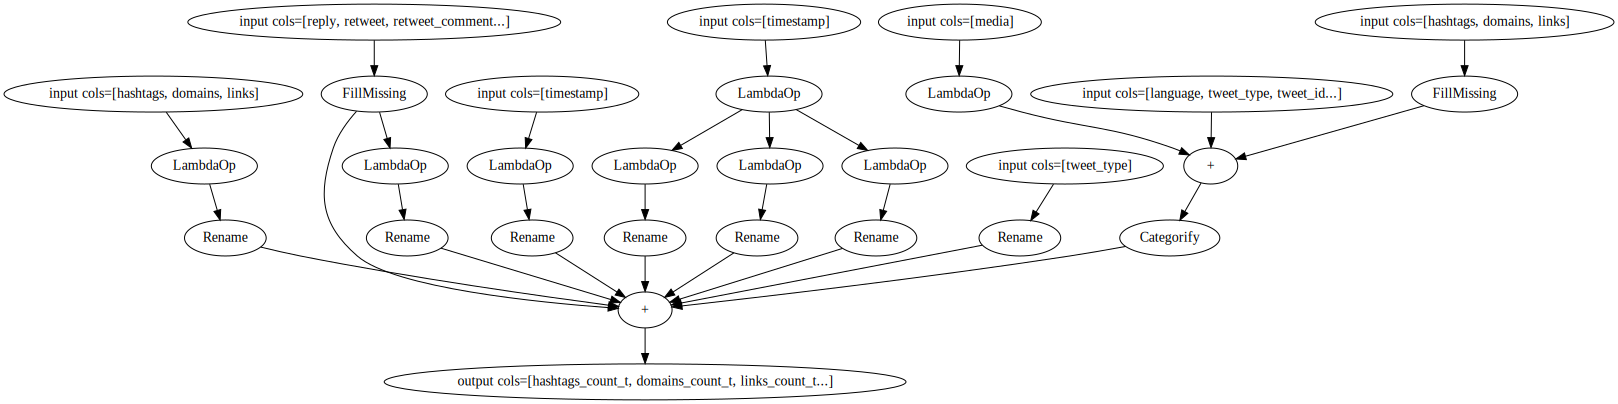

In [45]:
output = count_features+cat_features+label_name_feature+weekday+labels+hour+minute+seconds+tweet_type_raw
(output).graph

In [46]:
remaining_columns = [x for x in features if x not in (output.columns+['text_tokens'])]
remaining_columns

['timestamp',
 'a_follower_count',
 'a_following_count',
 'a_is_verified',
 'a_account_creation',
 'b_follower_count',
 'b_following_count',
 'b_is_verified',
 'b_account_creation',
 'b_follows_a']

In [47]:
proc = nvt.Workflow(output+remaining_columns)

In [48]:
data_parts = []
for file in os.listdir(BASE_DIR):
    if file.endswith(".tsv"):
        data_parts.append(os.path.join(BASE_DIR, file))

trains_itrs = nvt.Dataset(data_parts, 
                          header=None, 
                          names=features, 
                          engine='csv', 
                          sep='\x01', 
                          part_size='2GB')

In [49]:
client = Client(cluster)  # Sample client connecting to `cluster` object
client.run(cudf.set_allocator, "managed")  # Uses managed memory instead of "default"
import torch, gc
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/site-packages/distributed/client.py:1140: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [50]:
time_preproc_start = time.time()
proc.fit(trains_itrs)
time_preproc = time.time()-time_preproc_start
time_preproc

154.5443935394287

In [51]:
# We define the output datatypes for continuous columns to save memory. We can define the output datatypes as a dict and parse it to the to_parquet function.
dict_dtypes = {}
for col in LABEL_COLUMNS + ['media', 'language', 'tweet_type', 'tweet_id', 
                         'a_user_id', 'b_user_id', 'hashtags', 'domains', 
                         'links', 'timestamp', 'a_follower_count', 
                         'a_following_count', 'a_account_creation',
                         'b_follower_count', 'b_following_count', 'b_account_creation']:
    dict_dtypes[col] = np.uint32

In [52]:
time_preproc_start = time.time()
proc.transform(trains_itrs).to_parquet(output_path=BASE_DIR + 'preprocess_analysis/', dtypes=dict_dtypes)
time_preproc += time.time()-time_preproc_start
time_preproc

231.63217663764954

In [53]:
import pandas as pd

df = dask_cudf.read_parquet(BASE_DIR + 'preprocess_analysis/*.parquet')
if 'text_tokens' in list(df.columns):
    df = df.drop('text_tokens', axis=1)

pd.set_option('display.max_rows', 100)
df.head(100)

,hashtags_count_t,domains_count_t,links_count_t,media,hashtags,domains,links,language,tweet_type,tweet_id,a_user_id,b_user_id,reply,retweet,retweet_comment,like,timestamp_wd,reply_engagement,retweet_engagement,retweet_comment_engagement,like_engagement,timestamp_hour,timestamp_minute,timestamp_second,tweet_type_raw,timestamp,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a
0,0,0,0,0,1,1,1,20,2,2883132,2513097,824160,0,0,0,0,5,0,0,0,0,17,23,54,Retweet,1613237034,2473,662,False,1261859734,169,339,False,1520886748,False
1,0,1,1,0,1,66233,113401,47,3,1334478,2570055,2579677,0,0,0,0,4,0,0,0,0,15,30,0,TopLevel,1613748600,4418640,228,True,1266804490,393,1190,False,1237570695,False
2,0,1,1,0,1,89689,518494,47,3,3696548,51913,4887078,0,0,0,1613388292,0,0,0,0,1,10,50,38,TopLevel,1613386238,219715,3685,True,1202617218,629,1473,False,1263176351,False
3,0,0,0,0,1,1,1,47,2,6214352,520585,4204396,0,0,0,0,4,0,0,0,0,4,24,0,Retweet,1613708640,2388283,13511,True,1251645191,123,200,False,1268276559,False
4,0,0,0,6,1,1,1,62,3,1369771,2450631,95473,0,0,0,1612587384,5,0,0,0,1,4,33,38,TopLevel,1612586018,414,720,False,1578273274,134,379,False,1483862063,True
5,0,0,0,0,1,1,1,11,1,6899501,344779,2294250,0,0,0,0,3,0,0,0,0,12,40,51,Quote,1613047251,673,561,False,1318013852,2322,996,False,1385942383,True
6,0,0,0,0,1,1,1,20,2,6113270,3287803,1181513,0,0,0,0,0,0,0,0,0,10,3,49,Retweet,1613383429,9879,95,False,1551982041,61,1008,False,1573893335,False
7,0,0,0,0,1,1,1,20,1,3702352,456052,297643,0,0,0,1614134640,2,0,0,0,1,2,10,56,Quote,1614132656,209681,141,False,1516334262,35,106,False,1581377629,False
8,0,0,0,0,1,1,1,47,2,6867952,328331,2308414,0,0,0,0,2,0,0,0,0,15,5,38,Retweet,1614179138,901,782,False,1401492344,9661,8573,False,1373060291,True
9,0,1,1,0,1,103044,524525,62,3,4482019,38756,4067366,0,0,0,1614175309,2,0,0,0,1,13,12,53,TopLevel,1614172373,881,583,False,1254934130,355,650,False,1589197420,False
